#### Set up

In [1]:
import os
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio.windows import Window
import json
from rasterio.transform import rowcol
import numpy as np                                                                       

# Clear Water Fiord Aerial
pan_dir = r"E:\2017_Beluga_CS\2017_Cumberland_Sound_Beluga_Analysis\2017_CS_Beluga_Photos & Maps\2017 Aug 07_Back Camera_BC"
whale_shp_path = r"E:\2017_Beluga_CS\2017_Cumberland_Sound_Beluga_Analysis\2017_CS_Beluga_Photos & Maps\2017 Aug 07_Back Camera_BC\Whale Shapefiles\Adult.shp"
crop_size = 738
cropped_images_dir = f'aerial_Aug7_{crop_size}'

dataSource = "Aerial"

# width: 878x585m 7360x4192  0.12~0.14m resolution
metadata_path = os.path.join(cropped_images_dir, 'metadata.json')

whale_gdf = gpd.read_file(whale_shp_path)
print(f"The coordinate system is {whale_gdf.crs.to_string()}.")

if 'Photo_ID' in whale_gdf.columns:
    # rename the column to "Photo-ID"
    whale_gdf = whale_gdf.rename(columns={'Photo_ID': 'Photo-ID'})
else:
    print('"Photo_ID" column not found.')
whale_gdf['ID'] = range(1, len(whale_gdf) + 1)
whale_gdf['Species'] = 'beluga'
whale_gdf.head(2)

The coordinate system is PROJCS["North_Pole_Lambert_Azimuthal_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",-100],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",SOUTH],AXIS["Northing",SOUTH]].


,Photo-ID,Duplicates,Coordinate,geometry,ID,Species
0,CS_20170807_2000350,0,"66.59, -67.329",POINT (1400928.68 -2184584.603),1,beluga
1,CS_20170807_2000350,0,"66.59, -67.329",POINT (1400924.678 -2184581.962),2,beluga


In [2]:
# Step 1: Identify the tiles that include targets using the 'Photo-ID' column
tiles_with_targets = whale_gdf['Photo-ID'].unique()
tiles_with_targets = tiles_with_targets[tiles_with_targets != None]

# Step 2: Group by 'Photo-ID' and list target IDs
tiles_to_targets = whale_gdf.groupby('Photo-ID')['ID'].apply(list)
print("Tiles to Target IDs Mapping:")
for tile, target_ids in tiles_to_targets.items():
    print(f"Tile: {tile}, Target IDs: {target_ids}")

Tiles to Target IDs Mapping:
Tile: CS_20170807_2000350, Target IDs: [1, 2]
Tile: CS_20170807_2000351, Target IDs: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
Tile: CS_20170807_2000352, Target IDs: [20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]
Tile: CS_20170807_2000440, Target IDs: [34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77]
Tile: CS_20170807_2000441, Target IDs: [78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]
Tile: CS_20170807_2000442, Target IDs: [142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,

#### Visualize crop windows

Tile: CS_20170807_2000350
Size: 7360 x 4912
Bounds: BoundingBox(left=1400401.6854148135, bottom=-2184981.1980809313, right=1401379.7603700135, top=-2183928.343048606)
----------
Tile: CS_20170807_2000351
Size: 7360 x 4912
Bounds: BoundingBox(left=1400090.144722644, bottom=-2185189.3924802807, right=1401060.8448524005, top=-2184136.467237191)
----------


(Affine(0.06554121013738107, -0.0994130340279889, 1400578.4615457894,
        -0.09924464419680018, -0.06565241486183002, -2184136.467237191),
 3765,
 3295)

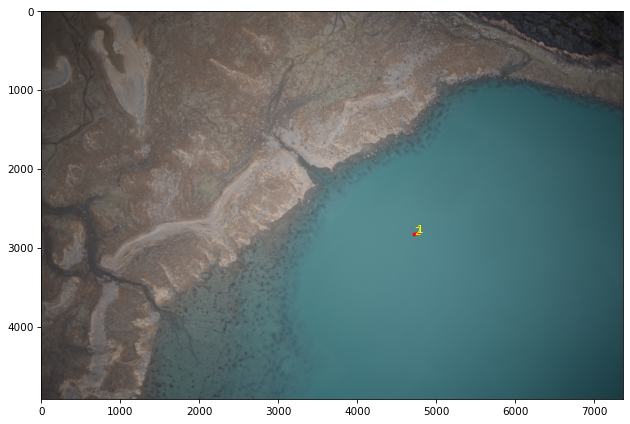

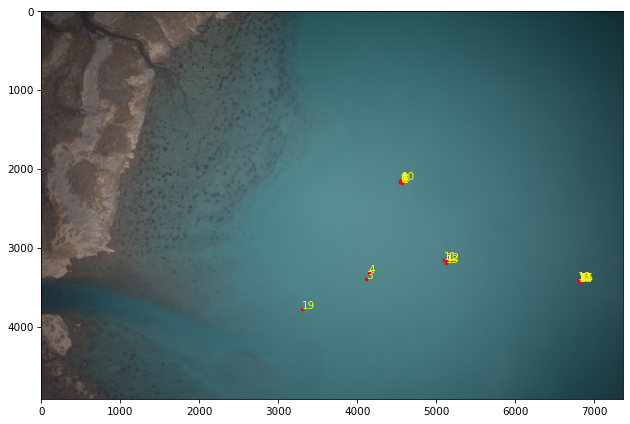

In [3]:
# Step 3: Iterate through the tiles containing whales, read each tile, and print the size of the imagery
dpi = 75
num_imgs_to_show = 2
cnt = 0
for tile in tiles_with_targets:
    pan_path = os.path.join(pan_dir, f'{tile[3:]}.jpg')
    if os.path.exists(pan_path):
        with rasterio.open(pan_path) as src:
            print(f"Tile: {tile}")
            print(f"Size: {src.width} x {src.height}")
            print(f"Bounds: {src.bounds}")
            print("----------")
            
            # Step 4: Visualize the imagery using Matplotlib
            fig, ax = plt.subplots(figsize=(10, 10), dpi=dpi)
            image_data = src.read([1, 2, 3])
            image_data = np.transpose(image_data, (1, 2, 0))  # (bands, rows, cols) -> (rows, cols, bands)
            ax.imshow(image_data)
            ax.set_xlim(0, src.width)
            ax.set_ylim(src.height, 0)
            raster_crs = src.crs
            whale_crs = whale_gdf.crs
            # print(f'annotation_crs: {whale_crs.to_string()}', '\n',f'raster_crs: {raster_crs.to_string()}')
            transform = src.transform
            whale_positions = whale_gdf[whale_gdf['Photo-ID'] == tile]
            for _, whale in whale_positions.iterrows():
                geom = whale.geometry
                x, y = geom.coords[0]
                row, col = rowcol(transform, x, y)
                ax.plot(col, row, marker='.', color='red', markersize=5, alpha=1)
                ax.text(col, row, str(whale['ID']), color='yellow', fontsize=10)
            
            # Create grid windows
            for row_start in range(0, src.height, crop_size):
                for col_start in range(0, src.width, crop_size):
                    window = Window(col_start, row_start, crop_size, crop_size)
                    window_bounds = src.window_bounds(window)
                    
                    # Unpack window_bounds
                    left, bottom, right, top = window_bounds
                    
                    # Plot grid windows
                    rect = plt.Rectangle((left, bottom),
                                         right - left,
                                         top - bottom,
                                         edgecolor='black', facecolor='black', linewidth=0.5, alpha=0.5)
                    ax.add_patch(rect)
        
    else:
        print(f"Tile file {pan_path} not found in directory {pan_dir}.")
    cnt += 1
    if cnt > num_imgs_to_show-1:
          break  # Remove this break if you want to process all tiles
transform, row, col

#### Crop

In [4]:
from utils import crop_aerial_tiles

crop_aerial_tiles(tiles_with_targets, pan_dir, whale_gdf, dataSource, crop_size=crop_size,
                  output_dir=cropped_images_dir, metadata_path=metadata_path, append=False)

Tile: 20170807_2000350  Size: 7360 x 4912
Bounds: BoundingBox(left=1400401.6854148135, bottom=-2184981.1980809313, right=1401379.7603700135, top=-2183928.343048606)
Tile: 20170807_2000351  Size: 7360 x 4912
Bounds: BoundingBox(left=1400090.144722644, bottom=-2185189.3924802807, right=1401060.8448524005, top=-2184136.467237191)
Tile: 20170807_2000352  Size: 7360 x 4912
Bounds: BoundingBox(left=1399775.3889915554, bottom=-2185396.22179312, right=1400744.6541429388, top=-2184343.323794287)
Tile: 20170807_2000440  Size: 7360 x 4912
Bounds: BoundingBox(left=1398344.2585286384, bottom=-2187037.171192033, right=1399293.2961107385, top=-2185985.8661126397)
Tile: 20170807_2000441  Size: 7360 x 4912
Bounds: BoundingBox(left=1398695.0334809404, bottom=-2186828.392662417, right=1399645.3181156553, top=-2185776.9306058176)
Tile: 20170807_2000442  Size: 7360 x 4912
Bounds: BoundingBox(left=1399040.1124240586, bottom=-2186617.0471531977, right=1399995.212843703, top=-2185565.0463631833)
Tile: 2017080

#### Crop visualization

reading file from ./aerial_Aug7_738\metadata.json


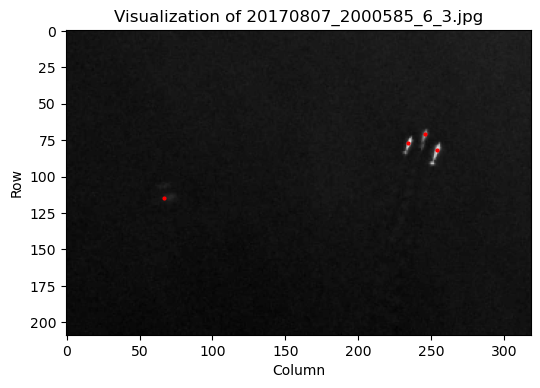

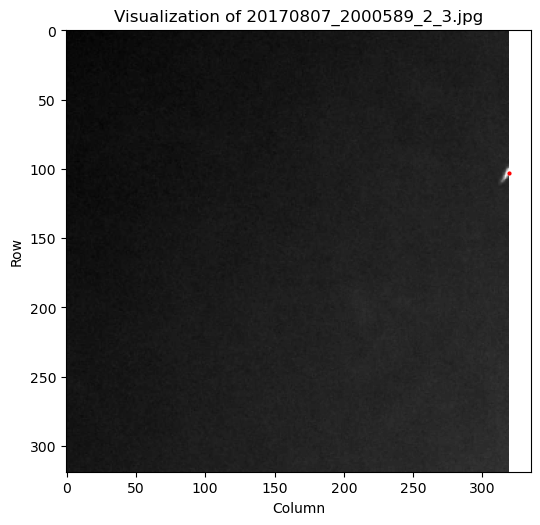

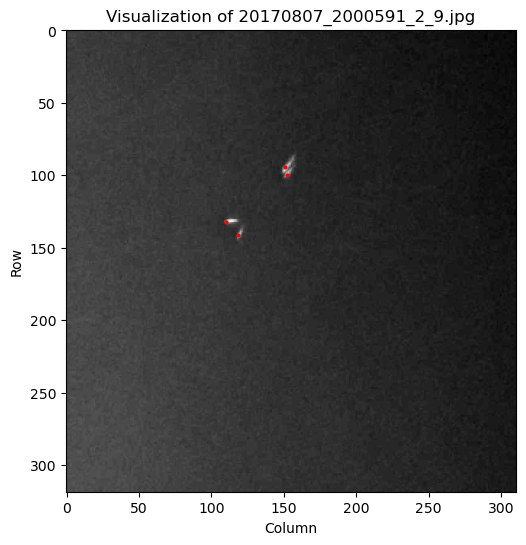

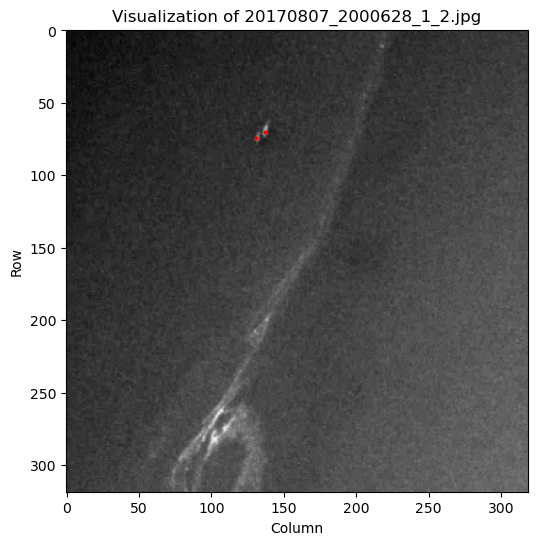

In [5]:
import random
import cv2
random.seed(41)
original_resolution = 0.13  # 0.13 meters per pixel
target_resolution = 0.30     # 0.30 meters per pixel
scale_factor = original_resolution / target_resolution  # 缩放因子



print('reading file from', os.path.join('./', metadata_path))
with open(metadata_path, 'r') as json_file:
    metadata = json.load(json_file)

# Iterate through all tiles in the metadata
for tile in metadata['tiles']:
    tile_url = tile['tileURL']
    tile_metadata_path = os.path.join(cropped_images_dir, tile_url)
    

    for window in tile['windows']:
        cropped_image_path = os.path.join(cropped_images_dir, window['dataURL'])

        if not os.path.exists(cropped_image_path):
            print(f"Cropped file {window['dataURL']} not found in directory {cropped_images_dir}.")
            continue
        
         # read RGB image using OpenCV
        crop_image = cv2.imread(cropped_image_path)
        crop_image_rgb = cv2.cvtColor(crop_image, cv2.COLOR_BGR2RGB)

        # randomly skip some images
        if random.random() > 0.02:
            continue
        new_width = int(crop_image.shape[1] * scale_factor)
        new_height = int(crop_image.shape[0] * scale_factor)
        
        # downsampling
        crop_image_rgb = cv2.resize(crop_image, (new_width, new_height), interpolation=cv2.INTER_AREA)
        # crop_image_rgb = cv2.resize(crop_image, (new_width, new_height), interpolation=cv2.INTER_LANCZOS4)
        crop_image_rgb = cv2.cvtColor(crop_image_rgb, cv2.COLOR_BGR2RGB)
        
        # convert to grayscale
        crop_image_rgb = cv2.cvtColor(crop_image_rgb, cv2.COLOR_RGB2GRAY)

        plt.figure(figsize=(6, 6), dpi=100)
        plt.imshow(crop_image_rgb, cmap='gray')
        plt.title(f"Visualization of {os.path.basename(cropped_image_path)}")

        # # Plot the object points
        for label in window['labels']:
            point_row, point_col = label['pointIndex']
            
            # 根据缩放因子调整点的位置
            point_row = int(point_row * scale_factor)
            point_col = int(point_col * scale_factor)
            
            # 在缩放后的图像上绘制点和标签
            plt.plot(point_col, point_row, marker='o', color='red', markersize=2)
            # plt.text(point_col_rescaled+5, point_row_rescaled, f'No. {label["originID"]}, {label["class"]}', color='yellow', fontsize=8)
        plt.xlabel('Column')
        plt.ylabel('Row')
        plt.show()

#### Save Downsampled Grayscale Image

In [6]:
from tqdm import tqdm

src_dir = f'./aerial_Aug7_{crop_size}'   # 0.13m RGB JPEG image
dst_dir = './aerial_Aug7_30cm_gray' # 0.3m gray scale, 3-channel image

if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
downsample_ratio = 0.13 / 0.30

for filename in tqdm(os.listdir(src_dir)):
    if filename.endswith('.jpg') or filename.endswith('.jpeg') or filename.endswith('.png'):
        img_path = os.path.join(src_dir, filename)
        img = cv2.imread(img_path)
        if img is None:
            print(f"failed to read image: {img_path}")
            continue

        height, width = img.shape[:2]

        new_width = int(width * downsample_ratio)
        new_height = int(height * downsample_ratio)

        img_resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
        gray_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
        gray_3channel = cv2.merge([gray_img, gray_img, gray_img])
        save_path = os.path.join(dst_dir, filename)
        cv2.imwrite(save_path, gray_3channel)

print("Done!")

100%|██████████| 861/861 [00:02<00:00, 366.12it/s]

Done!
